# Units

Questions about the parameters:  
Protons Flux ? How is it defined (protons/sec) ?  
Check formula for D ? Right stdev ?  
Right noise ? Not sure about this it.  

Positions in nm  
1 pixel is 100nm  
Image size: Nx * Ny * Nt  
Nx = Ny = 100 pixels  
Nt: number of frames 10   
Interframe positions: 10  
The mollecule always starts in the center of the first frame.  
delta_t: Time between two frames: 10 ms  
Generate images for a chosen D in [10^-1, 10] (micro_meter)^2/second  
Microscope FWHM (Full width half maximum): 100nm (later push up to 250nm)  
Flux: 10 photons/ms  
Amplitude of diraqs: Flux * delta_t /Interframe positions  
PSF (Point Spread function): start with Gaussian, then use specified one 


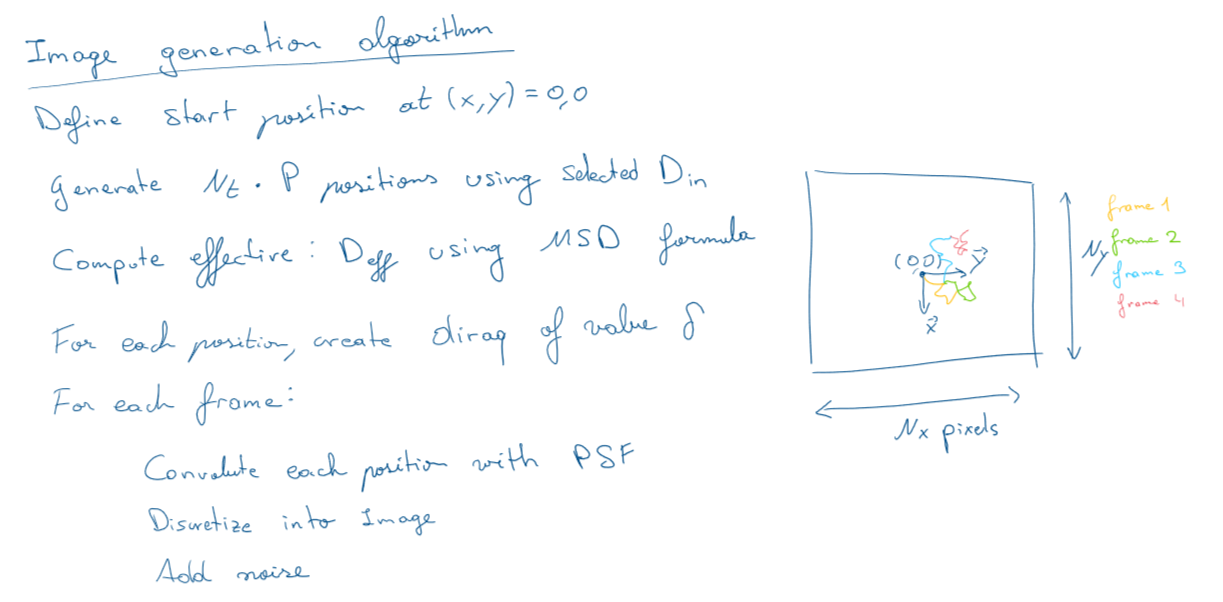

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats
from skimage.io import imsave
import time
import numpy as np
from skimage.measure import block_reduce
from skimage.util import random_noise
from sklearn.linear_model import LinearRegression


In [51]:
# Hyperparameters for simulation
nparticles = 1000   # Number of particles
nframes = 10    # Number of steps in the simulation
nposframe = 10    # Number of position per frame
dt = 0.01        # Integration time frame in second (time between two frames)
D = 1000.0        # Diffusion coefficient in nm^2 per s (=0.001 (um^2)/s)
num_steps = nframes*nposframe

# Hyperparameters for image generation
npixel = 30 # number of image pixels
pixelsize = 100 # in nm 
fwhm_psf = 200 # full width half maximum (emulates microscope)
factor_hr = 5 # image high resulution factor
flux = 100 # number of photons per s
poisson_noise = 10 
gaussian_noise = 10
background = 100 # base background value

In [86]:
def brownian_motion(nparticles, nframes, nposframe, D, dt, startAtZero=False):
    """
    Simulates the Brownian motion of particles over a specified number of frames 
    and interframe positions.

    Parameters:
    - nparticles (int): Number of particles to simulate.
    - nframes (int): Number of frames in the simulation.
    - nposframe (int): Number of interframe positions to calculate per frame.
    - D (float): Diffusion coefficient, influencing the spread of particle movement.
    - dt (float): Time interval between frames, affects particle displacement.
    - startAtZero (bool): If True, initializes the starting position at (0, 0).

    Returns:
    - trajectory (ndarray): Array of shape (nparticles, num_steps, 2) containing 
                            the x, y coordinates of each particle at each time step.
                            `num_steps` is calculated as `nframes * nposframe`.
    """
    num_steps = nframes * nposframe
    positions = np.zeros(2)
    trajectory = np.zeros((nparticles, num_steps, 2))
    
    # the formula for sigma might be wrong ?
    #https://en.wikipedia.org/wiki/Mean_squared_displacement#:~:text=In%20statistical%20mechanics%2C%20the%20mean,a%20reference%20position%20over%20time.
    #https://en.wikipedia.org/wiki/Gaussian_function
    sigma = np.sqrt(2 * D * dt / nposframe)
    #sigma = np.sqrt(4 * D * dt / nposframe)  # Standard deviation of step size based on D and dt

    for p in range(nparticles):
        # Generate random steps in x and y directions based on normal distribution
        dxy = np.random.randn(num_steps, 2) * sigma
        if startAtZero:
            dxy[0, :] = [0, 0]  # Set starting position at origin for the first step
        # Calculate cumulative sum to get positions from step displacements
        positions = np.cumsum(dxy, axis=0)
        trajectory[p] = positions

    return trajectory


def mean_square_displacement(traj):
    """
    Computes the Mean Square Displacement (MSD) for a particle trajectory, 
    which represents the average squared distance moved over time, useful 
    for analyzing diffusion characteristics.

    Parameters:
    - traj (ndarray): Array of shape (num_steps, 2) representing the x, y positions 
                      of a particle over time.

    Returns:
    - msd (ndarray): Array of MSD values computed for each time lag.
    """
    len = traj.shape[0]
    msd = np.zeros(len)
    for tao in range(len):
        # Calculate the square of displacements for each tao time t
        displacements = np.sum((traj[tao:] - traj[:len-tao])**2, axis=1)
        msd[tao] = np.mean(displacements)  # Average displacement for the given lag
    return msd

def mean_square_displacements(trajectories):
    """
    Computes the Mean Square Displacement (MSD) for multiple particle trajectories.
    The MSD represents the average squared distance moved over time, useful for
    analyzing diffusion characteristics for each particle.

    Parameters:
    - trajectories (ndarray): Array of shape (nparticles, num_steps, 2) representing
                              the x, y positions of each particle over time.

    Returns:
    - msd (ndarray): Array of MSD values with shape (nparticles, num_steps),
                     where each row corresponds to the MSD values of a particle.
    """
    nparticles, num_steps, _ = trajectories.shape
    msd = np.zeros((nparticles, num_steps))

    # Loop over each particle
    for p in range(nparticles):
        msd[p] = mean_square_displacement(trajectories[p,:,:])
    return msd



def show_plt(plt, title, xlabel='', ylabel='',legend=False):
    """
    A helper function to display plots with a uniform style and labeling.

    Parameters:
    - plt (matplotlib.pyplot): The matplotlib.pyplot module, used for plotting.
    - title (str): Title of the plot.
    - xlabel (str, optional): Label for the x-axis.
    - ylabel (str, optional): Label for the y-axis.

    Displays:
    - A styled plot with grid, labels, and title.
    """
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    if(legend):
        plt.legend()  # Uncomment if there are multiple series to label
    plt.show()

    
def gaussian_2d(xc, yc, sigma, grid_size, amplitude=1.0):
    """
    Generates a 2D Gaussian point spread function (PSF) centered at a specified position.

    Parameters:
    - xc, yc (float): The center coordinates (x, y) of the Gaussian within the grid.
    - sigma (float): Standard deviation of the Gaussian, controlling the spread (related to FWHM).
    - grid_size (int): Size of the output grid (grid will be grid_size x grid_size).
    - amplitude (float): Peak amplitude of the Gaussian function.

    Returns:
    - gauss (ndarray): A 2D array representing the Gaussian function centered at (xc, yc).
    """
    limit = (grid_size - 1) // 2  # Defines the range for x and y axes
    x = np.linspace(-limit, limit, grid_size)
    y = np.linspace(-limit, limit, grid_size)
    x, y = np.meshgrid(x, y)
    
    # Calculate the Gaussian function centered at (xc, yc)
    gauss = amplitude * np.exp(-(((x - xc) ** 2) / (2 * sigma ** 2) + ((y - yc) ** 2) / (2 * sigma ** 2)))
    return gauss


def add_noise_background(image, background, poisson_noise, gaussian_noise):
    """
    Adds background intensity and noise to an image, simulating microscopy imaging noise.

    Parameters:
    - image (ndarray): Input image to which noise and background will be added.
    - background (float): Mean intensity value of the background.
    - poisson_noise (float): Scale factor for Poisson noise, simulating photon shot noise.
    - gaussian_noise (float): Standard deviation for Gaussian noise, simulating electronic noise.

    Returns:
    - noisy (ndarray): A 16-bit unsigned integer array representing the noisy image.
    """
    # Add Gaussian noise to background intensity across the image
    background_image = image + np.clip(np.random.normal(background, gaussian_noise, image.shape), 
                                       0, background + 3 * gaussian_noise)
    
    # Normalize image to prepare for Poisson noise scaling
    maxi = np.max(background_image)
    image_normalized = background_image / maxi  # Normalization step
    
    # Apply Poisson noise (scaling by poisson_noise factor)
    noisy = maxi * poisson_noise * random_noise(image_normalized / poisson_noise, mode='poisson')
    return noisy.astype(np.uint16)


def plot1ParticleTrajectory(trajectory, nframes):

    plt.figure(figsize=(6, 6))
    for f in range(nframes):
        start =  f*nframes
        end = (f+1)* nframes + ( 1 if f != nframes-1 else 0)
        #print(start,end)
        plt.plot(trajectory[start:end, 0], trajectory[start:end, 1], lw=1, label=f'Frame {f}')
        
    show_plt(plt, f'Brownian Motion of 1 Particle with D={D}')




def computeAndPlotMeanMSD(msds, nparticles, nframes, nposframe):
    # Set up plot for Mean Square Displacement and diffusion coefficient estimation
    plt.figure(figsize=(4, 4))
    time_range = np.arange(nframes * nposframe) * dt / nposframe    # Time points for MSD plot
    #print(time_range)
    D_estimated = np.zeros(nparticles)  # Array to store estimated diffusion coefficients

    # Loop over each particle to calculate and plot its MSD
    for p in range(nparticles):
        plt.plot(time_range, msds[p], lw=0.25, label=f'Particle {p}')
        
        D_estimated[p] = estimateDfromMSD(msds[p],time_range)  # Diffusion coefficient from MSD slope (slope/4 for 2D diffusion)
        # Plot the linear fit line showing the MSD slope
        #plt.plot(time_range, slope * time_range , 'k--', lw=0.5, label=f'Slope for Particle {p}')


    mean_estimated_D =np.mean(D_estimated)
    plt.plot(time_range, mean_estimated_D *4* time_range , 'k--', lw=0.5, label=f'Slope for Particle {p}')

    # Display estimated diffusion coefficients for each particle
    print("Estimated Diffusion Coefficient:", mean_estimated_D)

    # Set plot details
    plt.title("Mean Square Displacement (MSD) and Estimated Diffusion Coefficient")
    plt.xlabel("Time (s)")
    plt.ylabel("MSD (nm^2)")
    #plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return mean_estimated_D

def estimateDfromMSD(msd,time_range):
    model = LinearRegression(fit_intercept=False)
    model.fit(time_range.reshape(-1, 1), msd)  # Fit model to data
    slope = model.coef_[0]
    D_estimated = slope / 4
    return D_estimated

def generateImagesAndGraphs(trajectory):
    frame_hr = np.zeros((nframes, npixel*factor_hr, npixel*factor_hr))
    frame_noisy = np.zeros((nframes, npixel, npixel))
    frame_lr = np.zeros((nframes, npixel, npixel))
    time_range = np.arange(nframes * nposframe) * dt / nposframe    # Time points for MSD plot
    fig, axs = plt.subplots(6, 5, figsize=(5*2, 2*6))

    for k in range(nframes):
        start = k*nposframe
        end = (k+1)*nposframe
        trajectory_segment = trajectory[start:end,:]
        xtraj = trajectory_segment[:,0]
        ytraj = trajectory_segment[:,1]
        # Generate frame, convolution, resampling, noise
        for p in range(nposframe):
            frame_spot = gaussian_2d(xtraj[p], ytraj[p], 2.35*fwhm_psf/pixelsize, npixel*factor_hr, flux) 
            frame_hr[k] += frame_spot
        frame_lr[k] = block_reduce(frame_hr[k], block_size=factor_hr, func=np.mean)
        frame_noisy[k] = add_noise_background(frame_lr[k], background, poisson_noise, gaussian_noise)
        # Save frames
        #imsave(f'images/HighRes/frame-T{k:03d}.tif', frame_hr[k].astype(np.float32), check_contrast=False)
        #imsave(f'images/Frames/frame-P{poisson_noise}-G{gaussian_noise}-T{k:03d}.tif', frame_noisy[k].astype(np.uint16), check_contrast=False)
        
        # Plot
        if k < 6:
            axs[k,0].imshow(frame_noisy[k], cmap='gray',vmin=0)
            #axs[k,0].axis('off')
            axs[k,0].set_title(f'Noisy {np.mean(frame_noisy[k]):3.2f}')
            axs[k,1].imshow(frame_lr[k], cmap='gray',vmin=0)
            #axs[k,1].axis('off')
            axs[k,1].set_title(f'LowRes {np.mean(frame_lr[k]):3.2f}')
            axs[k,2].imshow(frame_hr[k], cmap='gray')
            #axs[k,2].axis('off')
            axs[k,2].set_title(f'HigRes {np.mean(frame_hr[k]):3.2f}')
            #plt.colorbar(shw)
            axs[k,3].plot(xtraj, -ytraj, lw=2, label=f'{k}')
            axs[k,3].set_title(f'Trace on frame {k}')
            #for kk in range(0,k): axs[k,2].plot(trajectory[:, kk, 0], -trajectory[:, kk, 1], lw=0.5, label=f'{kk}')
            axs[k,3].set_xlim(-50, 50)
            axs[k,3].set_ylim(-50, 50)
            start = k*nposframe
            end = (k+1)*nposframe
            msd = mean_square_displacement(trajectory_segment)
            
            D_estimated = estimateDfromMSD(msd,time_range[start:end])

            axs[k,4].plot(time_range[start:end], msd, lw=1, label=f'D={D_estimated:3.3}')
            axs[k,4].set_ylim(0, D)
            axs[k,4].set_title(f'MSD D={D_estimated:3.2f}')
    plt.suptitle(f'Simulator - Diffusion={D} FWHM={fwhm_psf} Factor HR={factor_hr}')    
    plt.tight_layout()
    plt.show()
    fig.savefig(f'simulator-D{D}-FWHM{fwhm_psf}-hr{factor_hr}.pdf', bbox_inches='tight')


def generateImageFromTrajectory(trajectory):
    frame_hr = np.zeros((nframes, npixel * factor_hr, npixel * factor_hr))
    frame_noisy = np.zeros((nframes, npixel, npixel))
    frame_lr = np.zeros((nframes, npixel, npixel))

    for k in range(nframes):
        start = k * nposframe
        end = (k + 1) * nposframe
        trajectory_segment = trajectory[start:end, :]
        xtraj = trajectory_segment[:, 0]
        ytraj = trajectory_segment[:, 1]

        # Generate frame, convolution, resampling, noise for each frame
        for p in range(nposframe):
            frame_spot = gaussian_2d(xtraj[p], ytraj[p], 2.35 * fwhm_psf / pixelsize, npixel * factor_hr, flux)
            frame_hr[k] += frame_spot

        frame_lr[k] = block_reduce(frame_hr[k], block_size=factor_hr, func=np.mean)
        frame_noisy[k] = add_noise_background(frame_lr[k], background, poisson_noise, gaussian_noise)

    return frame_hr,frame_noisy

def generateAndPlotMultipleDiffusionSequences(diffusion_coefficients):
    """
    Generates and displays image sequences for multiple diffusion coefficients,
    showing each sequence in a horizontal plot.

    Parameters:
    - diffusion_coefficients (list of float): List of diffusion coefficients to simulate.

    Returns:
    - None. Displays a horizontal plot of image sequences for each diffusion coefficient.
    """
    n_diffusions = len(diffusion_coefficients)
    fig, axs = plt.subplots(n_diffusions, 5, figsize=(5 * 2, 2 * n_diffusions))

    # Generate images and graphs for each diffusion coefficient
    for i, D in enumerate(diffusion_coefficients):
        trajectory = brownian_motion(1, nframes, nposframe, D, dt)[0]
        print('Estimated D:', estimateDfromMSD(mean_square_displacement(trajectory),np.arange(nframes * nposframe) * dt / nposframe))
        frame_hr,frame_noisy = generateImageFromTrajectory(trajectory)
        for k in range(nframes):
            # Plot images and trajectory for each frame
            if k < 5:
                axs[i, k].imshow(frame_noisy[k], cmap='gray', vmin=0,vmax=1000)
                axs[i, k].set_title(f'D={D}, Frame {k}')
                axs[i, k].axis('off')

        # Add title for each row
        axs[i, 0].set_ylabel(f'D={D}', rotation=0, labelpad=60, fontsize=12)

    plt.suptitle("Image Sequences for Different Diffusion Coefficients")
    plt.tight_layout()
    plt.show()

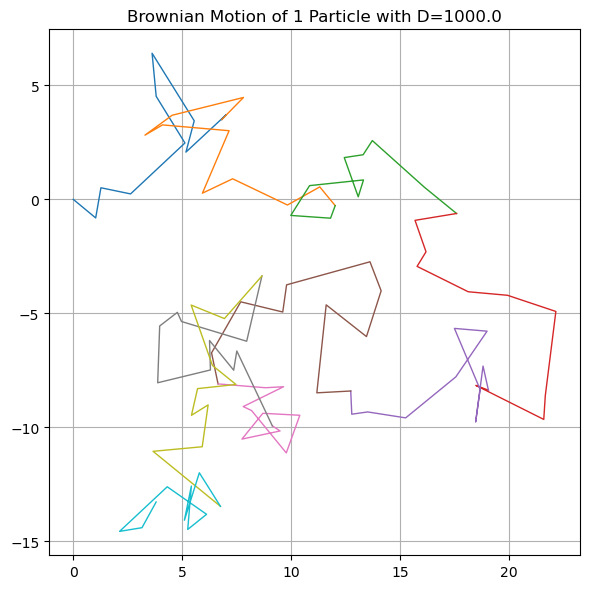

In [87]:
trajectory = brownian_motion(1, nframes, nposframe, D, dt,True)[0,:,:]
plot1ParticleTrajectory(trajectory, nframes)

Estimated Diffusion Coefficient: 952.1488352498084


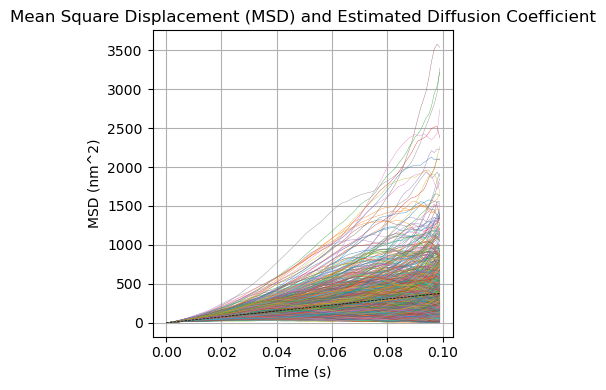

In [88]:
trajectories = brownian_motion(nparticles, nframes, nposframe, D, dt,True)
msds =  mean_square_displacements(trajectories) 
mean_estimated_D = computeAndPlotMeanMSD(msds,nparticles,nframes,nposframe)


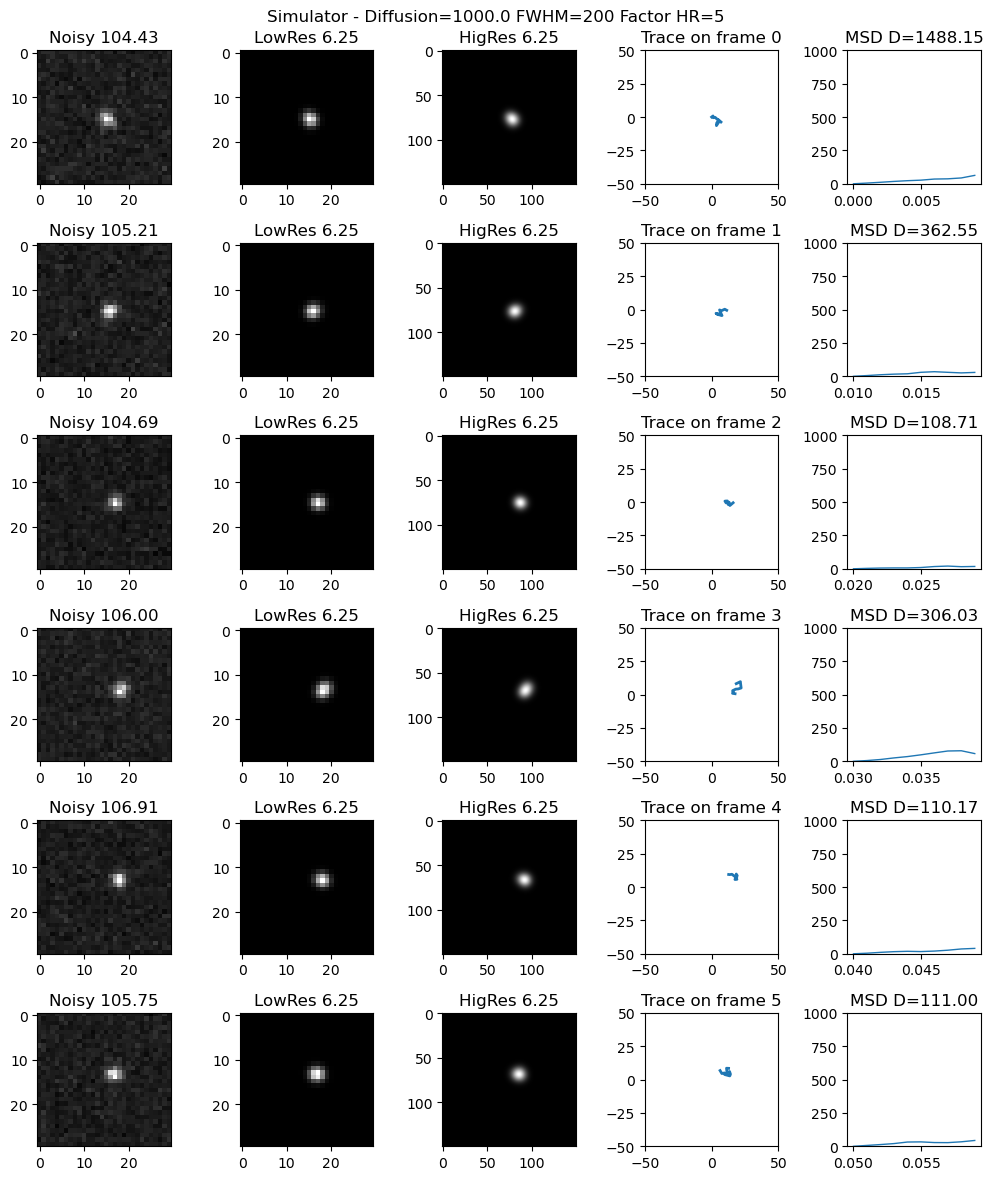

In [89]:
generateImagesAndGraphs(trajectory)

Estimated D: 330.38372391609255
Estimated D: 228.05712390495947
Estimated D: 2957.95376503809
Estimated D: 14946.477821012999
Estimated D: 36596.71465336596


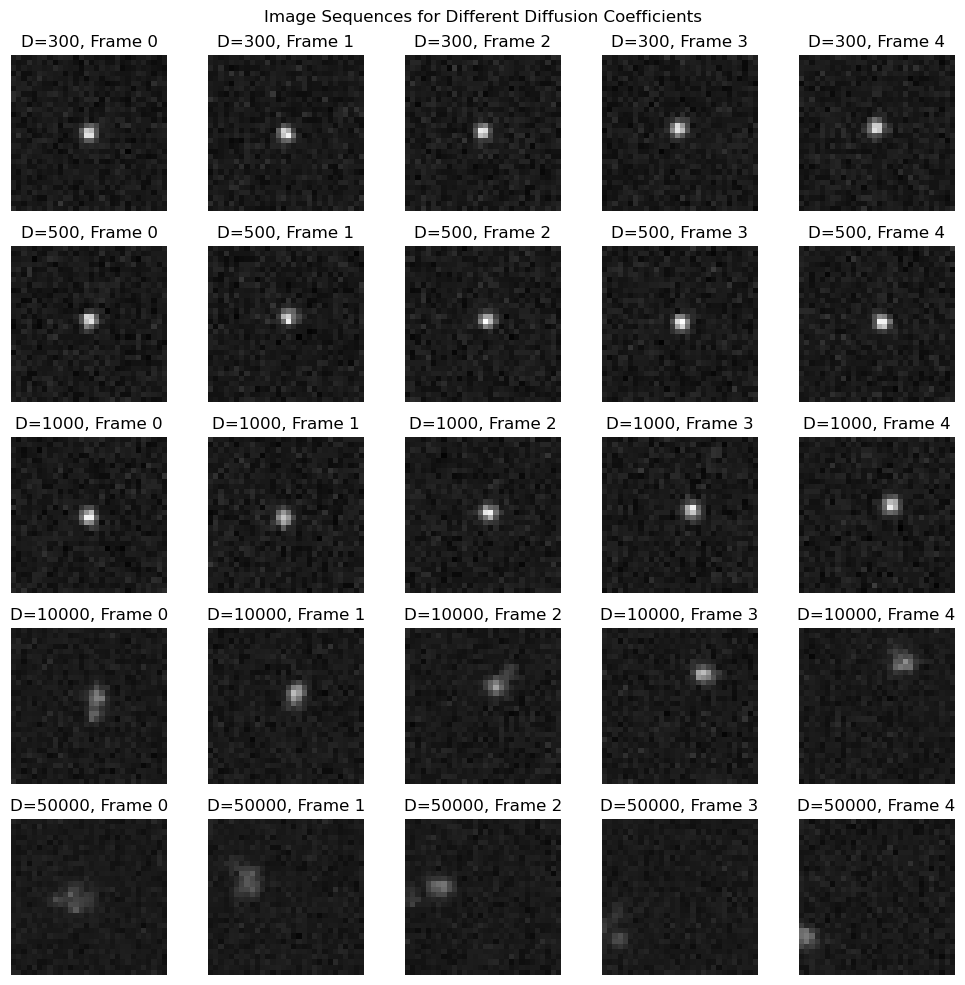

In [96]:
generateAndPlotMultipleDiffusionSequences([300,500,1000,10000,50000])

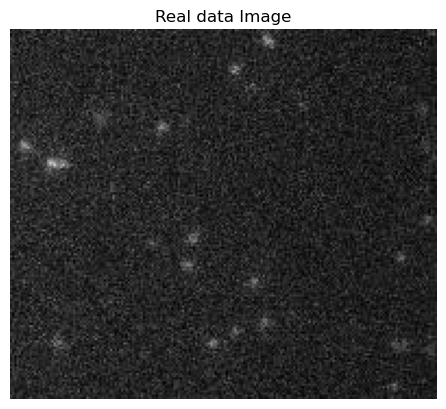

Minimum intensity: 0.00
Maximum intensity: 221.00
Mean intensity: 37.53


In [91]:
import matplotlib.pyplot as plt
from skimage import io
import numpy as np

# Load the image and convert to grayscale
grayscale_image = io.imread('./real-data/snapshot.png')

# Display the image
plt.imshow(grayscale_image, cmap='gray')
plt.axis('off')
plt.title("Real data Image")
plt.show()

# Calculate and print intensity statistics
min_intensity = np.min(grayscale_image)
max_intensity = np.max(grayscale_image)
mean_intensity = np.mean(grayscale_image)

print(f"Minimum intensity: {min_intensity:.2f}")
print(f"Maximum intensity: {max_intensity:.2f}")
print(f"Mean intensity: {mean_intensity:.2f}")